In [1]:
# notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 0.7
mpl.rcParams['figure.figsize'] = (6, 4)

# standard
from datetime import datetime, timedelta 

# third party
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

# Investigate Florida county linelist

Data can be downloaded at https://www.arcgis.com/home/item.html?id=37abda537d17458bae6677b8ab75fcb9.

In [2]:
df = pd.read_csv("~/Downloads/Case_Data (1).csv", parse_dates=["Case_", "EventDate", "ChartDate"])
df = df[df.EventDate > datetime(2020, 3, 1)]

In [3]:
# Event date is the earliest of these three dates: onset date, diagnosis date, or test date.
df.head(3)

,County,Age,Age_group,Gender,Jurisdiction,Travel_related,Origin,EDvisit,Hospitalized,Died,Case,Contact,Case_,EventDate,ChartDate
0,Palm Beach,43.0,35-44 years,Female,FL resident,No,NaN,NO,NO,NaN,Yes,Yes,2020-06-19 05:00:00,2020-06-07,2020-06-19 05:00:00
1,Palm Beach,35.0,35-44 years,Male,FL resident,No,NaN,NO,NO,NaN,Yes,Yes,2020-06-19 05:00:00,2020-06-19,2020-06-19 05:00:00
2,Hendry,52.0,45-54 years,Female,FL resident,No,NaN,YES,NO,NaN,Yes,YES,2020-06-19 05:00:00,2020-06-17,2020-06-19 05:00:00


In [4]:
print(df.Case.unique()) # all positive cases
print(df.shape)
print(df.ChartDate.max())
df.groupby(["Age_group"]).count().Case # enough samples for each age group

['Yes' nan]
(717480, 15)
2020-10-04 05:00:00


Age_group
0-4 years       12256
15-24 years    114807
25-34 years    131510
35-44 years    114942
45-54 years    112998
5-14 years      30516
55-64 years     93274
65-74 years     55365
75-84 years     32148
85+ years       18602
Unknown          1046
Name: Case, dtype: int64

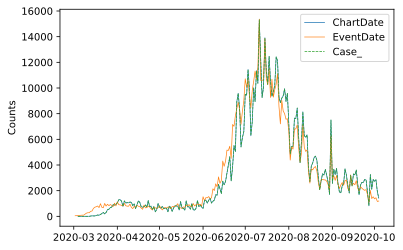

In [5]:
plt.plot(df.groupby(df.ChartDate.dt.date).count().ChartDate, label="ChartDate")
plt.plot(df.groupby(df.EventDate.dt.date).count().EventDate, label="EventDate")
plt.plot(df.groupby(df.Case_.dt.date).count().Case_, label="Case_", linestyle="--")
plt.ylabel("Counts")
plt.legend()
plt.show()

In [6]:
np.sum(np.abs(df.ChartDate - df.Case_)) # ChartDate == Case_

Timedelta('0 days 00:00:00')

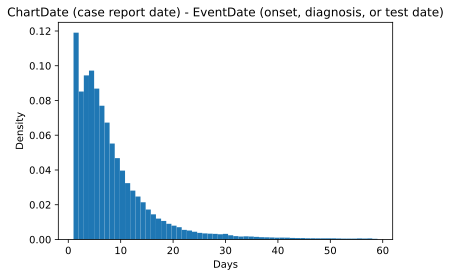

In [7]:
df["delay"] = (df.ChartDate - df.EventDate).dt.days
df = df[df.delay.gt(0) & df.delay.lt(60)]
plt.hist(df.delay, bins=60-1, density=True)
plt.title("ChartDate (case report date) - EventDate (onset, diagnosis, or test date)")
plt.ylabel("Density")
plt.xlabel("Days")
plt.show()

In [8]:
print(df.delay.median())
print(df.delay.mean())
print(df.delay.std())

6.0
8.192074349935353
8.149786582753762


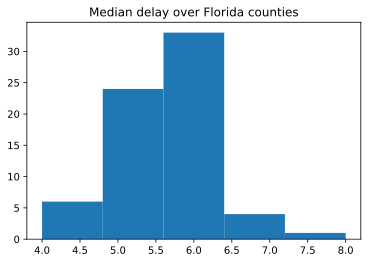

array(['Palm Beach', 'Hendry', 'Dade', 'Alachua', 'Duval', 'Pinellas',
       'Nassau', 'Hillsborough', 'Orange', 'Polk', 'Broward', 'Lee',
       'Pasco', 'Brevard', 'Levy', 'Flagler', 'Wakulla', 'Collier',
       'Escambia', 'Bay', 'Okaloosa', 'Gadsden', 'Martin', 'Manatee',
       'Highlands', 'Volusia', 'Lake', 'Sarasota', 'Suwannee', 'Sumter',
       'Osceola', 'Marion', 'Leon', 'Baker', 'St. Lucie', 'Charlotte',
       'Hernando', 'Seminole', 'Bradford', 'Clay', 'Indian River',
       'Monroe', 'Hardee', 'Citrus', 'Holmes', 'Columbia', 'Madison',
       'Santa Rosa', 'St. Johns', 'Jefferson', 'Calhoun', 'Walton',
       'Putnam', 'Jackson', 'Lafayette', 'Dixie', 'Okeechobee', 'Taylor',
       'Liberty', 'Gulf', 'Hamilton', 'Unknown', 'Desoto', 'Washington',
       'Union', 'Franklin', 'Gilchrist', 'Glades'], dtype=object)

In [9]:
plt.hist(df.groupby("County").delay.median(), bins=5)
plt.title("Median delay over Florida counties")
plt.show()

df.County.unique()

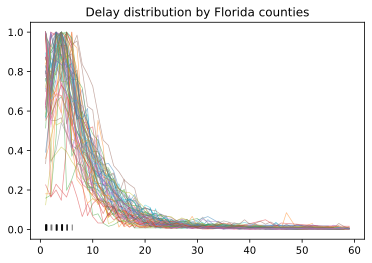

In [10]:
grouped_df = df.groupby("County")
peak_delay = []
for loc in grouped_df.groups.keys():
    sub_df = grouped_df.get_group(loc)
    sub_delay_dist = sub_df.delay.value_counts().sort_index()
    sub_delay_dist /= sub_delay_dist.max()
    peak_delay.append(sub_delay_dist.index[np.argmax(sub_delay_dist)] + np.random.rand(1)*0.25)
    plt.plot(sub_delay_dist.index, sub_delay_dist.values, alpha=0.5, label=loc)

plt.plot(peak_delay, [0.01]*len(grouped_df.groups.keys()), '|', color='k', alpha=0.3)
plt.title("Delay distribution by Florida counties")
plt.show()

## Comparison to International Listlist

International linelist source: https://github.com/beoutbreakprepared/nCoV2019/tree/master/latest_data. Keep in mind that Florida's EventDate (our proxy for symptom onset date) may include diagnosis or test dates. 

In [11]:
# Columns:
# ID,age,sex,city,province,country,latitude,longitude,geo_resolution,
# date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,
# lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,
# additional_information,chronic_disease_binary,chronic_disease,source,sequence_available,
# outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1
# country_new,admin_id,data_moderator_initials,travel_history_binary
intl_df = pd.read_csv("~/Downloads/latestdata.csv",
                     usecols=["country", "city", "province", 
                              "date_onset_symptoms", "date_confirmation"],
                     low_memory=False)
intl_df = intl_df[intl_df[["date_onset_symptoms" , "date_confirmation"]].notna().all(axis=1)]
intl_df = intl_df[intl_df['date_confirmation'].str.len().eq(10) &
                  intl_df['date_onset_symptoms'].str.len().eq(10)] # proper date format

# bad dates
intl_df = intl_df.replace("01.31.2020", "31.01.2020")
intl_df = intl_df.replace("31.04.2020", "01.05.2020")
intl_df['date_onset_symptoms'] =  pd.to_datetime(intl_df['date_onset_symptoms'], format='%d.%m.%Y')
intl_df['date_confirmation'] =  pd.to_datetime(intl_df['date_confirmation'], format='%d.%m.%Y')

In [12]:
intl_df.head(3)

,city,province,country,date_onset_symptoms,date_confirmation
53,"Dongliao County, Liaoyuan City",Jilin,China,2020-02-08,2020-02-14
55,"Shuangliao City, Siping City",Jilin,China,2020-02-01,2020-02-13
335,Mei Hwan Drive,NaN,Singapore,2020-01-30,2020-02-14


In [13]:
intl_df.country.unique()

array(['China', 'Singapore', 'Japan', 'South Korea', 'Malaysia', nan,
       'Italy', 'Finland', 'Canada', 'Pakistan', 'Germany', 'Brazil',
       'Croatia', 'Spain', 'United States', 'Romania', 'Cambodia',
       'Iceland', 'Tunisia', 'Portugal', 'Nepal', 'Australia',
       'Philippines', 'South Africa', 'Bhutan', 'France', 'Malta',
       'Switzerland', 'Vietnam', 'Thailand', 'Angola', 'Burkina Faso',
       'Cabo Verde', 'Central African Republic', "Cote d'Ivoire", 'Gabon',
       'Sudan', 'Uganda', 'Algeria', 'Gambia', 'Namibia', 'Nigeria',
       'India', 'Argentina', 'Bolivia', 'Guatemala', 'Mexico', 'Chile',
       'Cuba', 'Colombia'], dtype=object)

In [14]:
us_df = intl_df[intl_df.country.eq('United States')]
print(us_df.head(3))
print(us_df.shape) # only 28 observations for US!

                city    province        country date_onset_symptoms  \
3358     Los Angeles  California  United States          2020-01-22   
8370  Douglas County    Nebraska  United States          2020-03-05   
8381   Ramsey County   Minnesota  United States          2020-02-25   

     date_confirmation  
3358        2020-01-26  
8370        2020-03-06  
8381        2020-03-06  
(28, 5)


In [15]:
intl_delay = (intl_df['date_confirmation'] - intl_df['date_onset_symptoms']).dt.days
intl_delay = intl_delay[intl_delay.gt(0) & intl_delay.lt(60)] 

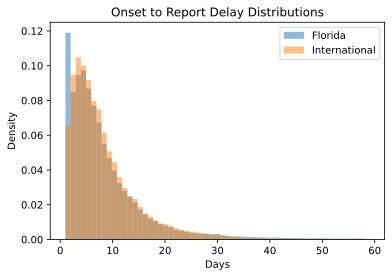

In [16]:
plt.hist(df.delay, bins=60-1, density=True, alpha=0.5, label="Florida")
plt.hist(intl_delay, bins=60-1, density=True, alpha=0.5, label="International")
plt.legend()
plt.title("Onset to Report Delay Distributions")
plt.ylabel("Density")
plt.xlabel("Days")
plt.show()

In [17]:
print(intl_delay.median())
print(intl_delay.mean())
print(intl_delay.std())

6.0
8.020131031012815
6.747939220713321


## Changes over time

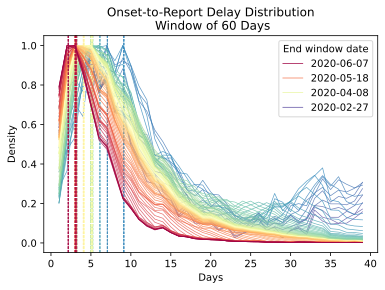

In [18]:
n_window = 60 # day window
earliest_date = intl_df.date_onset_symptoms.min()
latest_date = intl_df.date_onset_symptoms.max()

median_ests = []
earliest_train_dates = []
last_train_date = []
dist_est = []
for i in range((latest_date - timedelta(n_window) - earliest_date).days):
    sub_df = intl_df[intl_df.date_onset_symptoms.gt(latest_date - timedelta(n_window)) &
                     intl_df.date_onset_symptoms.le(latest_date)]
    sub_delay = (sub_df['date_confirmation'] - sub_df['date_onset_symptoms']).dt.days
    sub_delay = sub_delay[sub_delay.gt(0) & sub_delay.lt(40)]
    sub_delay_dist = sub_delay.value_counts().sort_index()
    sub_delay_dist /= sub_delay_dist.max()
    latest_date = latest_date - timedelta(1)
    earliest_train_dates.append(latest_date - timedelta(n_window))
    last_train_date.append(latest_date)
    median_ests.append(sub_delay.median())
    dist_est.append(sub_delay_dist)
    
    
colors = cm.Spectral(np.linspace(0, 1, len(dist_est)))
fig, ax = plt.subplots()
n_dist = len(dist_est)
for i in range(n_dist-1, -1, -1):
    plt.plot(dist_est[i].index, dist_est[i].values, color=colors[i], alpha=0.8)
    plt.axvline(dist_est[i].index[np.argmax(dist_est[i])] + np.random.rand(1)*0.25,
                color=colors[i], linestyle="--")

plt.legend([Line2D([0], [0], color=colors[i]) for i in [0, 20, 60, n_dist - 1]], 
           [last_train_date[i].date() for i in [0, 20, 60, n_dist - 1]],
           title = "End window date")
plt.ylabel("Density")
plt.xlabel("Days")
plt.title(f"Onset-to-Report Delay Distribution\n Window of {n_window} Days")
plt.savefig("mw_onset_delay_dist.pdf")
plt.show()

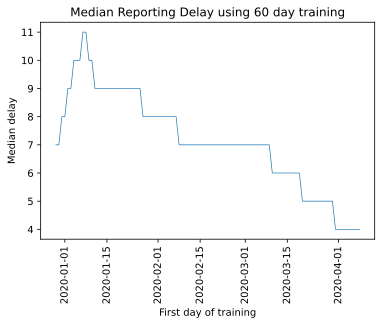

In [19]:
median_over_time = pd.DataFrame({"earliest_train_dates": earliest_train_dates,
                                 "median_delay" : median_ests})
plt.plot(median_over_time.earliest_train_dates, median_over_time.median_delay)
plt.title("Median Reporting Delay using 60 day training")
plt.xlabel("First day of training")
plt.xticks(rotation="90")
plt.ylabel("Median delay")
plt.show()

### See FB survey symptom rate vs. cases.

In [20]:
import covidcast
fb_data = covidcast.signal("fb-survey", "smoothed_hh_cmnty_cli",
                           datetime(2020, 6, 15), datetime(2020, 8, 15), "state")
fb_data["cases"] = (fb_data.value/100) * fb_data.sample_size

case_data = covidcast.signal("indicator-combination", "confirmed_7dav_incidence_num",
                        datetime(2020, 6, 15), datetime(2020, 8, 15), "state")

In [21]:
cases = case_data[case_data.geo_value.eq("fl")]
fb = fb_data[fb_data.geo_value.eq("fl")]
# scaled_fb = cases.min() + ((fb - fb.min()) * (cases.max() - cases.min()))/(fb.max() - fb.min())

The FB survey does look to be slightly leading the reported cases. 

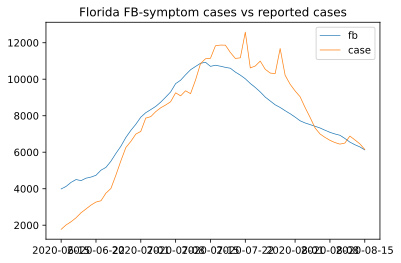

In [22]:
plt.plot(fb.time_value, fb.cases.values, label="fb")
plt.plot(cases.time_value, cases.value.values, label="case")
plt.title("Florida FB-symptom cases vs reported cases")
plt.legend()
plt.show()